<a href="https://colab.research.google.com/github/hoangviet-nguyen/bveri-abschluss-projekt/blob/main/projekt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
from google.colab import drive
import sys
drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/bveri/Bveri-Abschluss')

InteractiveShell.ast_node_interactivity = "all"

try:
    import jupyter_black

    jupyter_black.load()
except:
    print("black not installed")

ModuleNotFoundError: No module named 'google'

# Projekt: Under Water Image Segmentation

In [2]:
import os
from pathlib import Path
import SuimSet
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms.v2 import functional as TF
import torch
import torchshow as ts
from torch.utils.data import Dataset
from typing import Callable
import torchinfo
from torch import nn
from torch.nn import functional as F
from tqdm.notebook import tqdm
from Unet import Decoder, Encoder, UNet
from SuimNet import RSBEncoder, RSBDecoder, SuimNet

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## Download dataset: SUIM dataset

In [4]:
DATA_PATH = Path("./workspace/code/data")

if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)
    SuimSet.download(DATA_PATH)

## Data Inspection

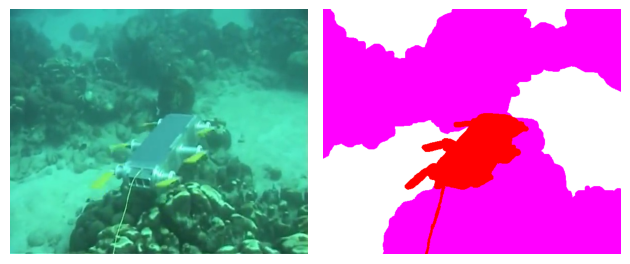

In [5]:
root_path = DATA_PATH.joinpath("train_val/train_val")
norm_img = Image.open(root_path.joinpath("images/d_r_1_.jpg"))
norm_img = np.array(norm_img)

label_img = Image.open(root_path.joinpath("masks/d_r_1_.bmp"))
label_img = np.array(label_img) / 255
imgs = [norm_img, label_img]

fig, axs = plt.subplots(ncols=2)
for img, ax in zip(imgs, axs.flatten()):
    ax.imshow(img)
    ax.axis("off")

plt.tight_layout()
plt.show();

## Building a dataset

In [6]:
class SuimDataSet(Dataset):
    def __init__(
        self,
        root_path: Path,
        transform_images: Callable = None,
        transform_labels: Callable = None,
    ):
        """
        Initializes the dataset.

        Args:
            root_path (Path): Path to the dataset directory.
            transform_images (callable, optional): Transformation function for images.
            transform_labels (callable, optional): Transformation function for labels.
        """

        self.root_path = root_path
        self.transform_images = transform_images
        self.transform_labels = transform_labels
        self.image_paths = list((root_path / "images").glob("*.jpg"))

        self.rgb_to_class = {
            (0, 0, 0): 0,  # Black - Background waterbody
            (0, 0, 255): 1,  # Blue - Human divers
            (0, 255, 0): 2,  # Green - Plants/sea-grass
            (0, 255, 255): 3,  # Sky blue - Wrecks/ruins
            (255, 0, 0): 4,  # Red - Robots/instruments
            (255, 0, 255): 5,  # Pink - Reefs/invertebrates
            (255, 255, 0): 6,  # Yellow - Fish and vertebrates
            (255, 255, 255): 7,  # White - Sea-floor and rocks
        }

    def __len__(self) -> int:
        return len(self.image_paths)

    def __getitem__(
        self, idx: int
    ) -> tuple[torch.Tensor | Image.Image, torch.Tensor, torch.Tensor]:
        """
        Retrieves the image and corresponding label masks for a given index.

        Args:
            idx (int): The index of the item to retrieve.

        Returns:
            tuple: A tuple containing:
                - image (torch.Tensor | Image.Image): The transformed image or original image.
                - label_masks (torch.Tensor): A binary mask tensor of shape (K, H, W) where K is the number of classes.
                  Each channel represents the binary mask for a specific class.
                - labels_tensor (torch.Tensor): A segmentation map tensor of shape (1, H, W) indicating class indices
                for each pixel.
        """
        image_path = self.image_paths[idx]
        image = Image.open(image_path)

        label_path = self.root_path / f"masks/{image_path.stem}.bmp"
        label_img = np.array(Image.open(label_path)) / 255
        labels = np.zeros(label_img.shape[:2], dtype=np.int64)

        for rgb, class_idx in self.rgb_to_class.items():
            x, y, _ = np.where(label_img == np.array(rgb))
            labels[x, y] = class_idx

        labels_tensor = torch.tensor(labels).unsqueeze(0)
        label_masks = torch.zeros(len(self.rgb_to_class), *labels.shape).scatter_(
            0, labels_tensor, 1
        )

        if self.transform_images:
            image = self.transform_images(image)
        if self.transform_labels:
            label_masks = self.transform_labels(label_masks)
            labels_tensor = self.transform_labels(labels_tensor)

        return image, label_masks, labels_tensor

In [7]:
train_path = DATA_PATH.joinpath("train_val/train_val")
test_path = DATA_PATH.joinpath("TEST/TEST")

ds_train = SuimDataSet(root_path=train_path)
ds_test = SuimDataSet(root_path=test_path)

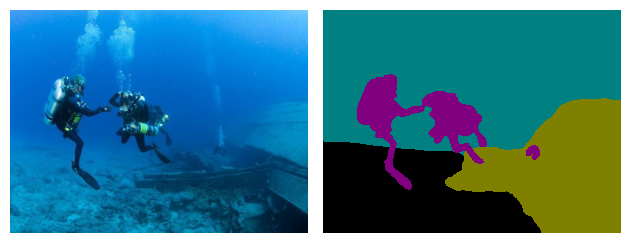

In [8]:
observation, label_masks, label_tensor = ds_train[0]
ts.show([observation, label_tensor])

## Fully-Convolutional Network

### Encoder Block

### Decoder Block

### Encoder / Decoder

In [9]:
start = 16
encoder = Encoder(start=start, num_blocks=6)
decoder = Decoder(start=start, num_blocks=6)
encoder_decoder = UNet(encoder=encoder, decoder=decoder, n_classes=8, start=start)
print(torchinfo.summary(encoder_decoder, input_size=(1, 3, 320, 256)))

Layer (type:depth-idx)                        Output Shape              Param #
UNet                                          [1, 8, 320, 256]          --
├─Conv2d: 1-1                                 [1, 16, 320, 256]         448
├─Encoder: 1-2                                [1, 32, 160, 128]         --
│    └─ModuleList: 2-1                        --                        --
│    │    └─EncoderBlock: 3-1                 [1, 32, 160, 128]         23,328
│    │    └─EncoderBlock: 3-2                 [1, 64, 80, 64]           92,736
│    │    └─EncoderBlock: 3-3                 [1, 128, 40, 32]          369,792
│    │    └─EncoderBlock: 3-4                 [1, 256, 20, 16]          1,476,864
│    │    └─EncoderBlock: 3-5                 [1, 512, 10, 8]           5,902,848
│    │    └─EncoderBlock: 3-6                 [1, 1024, 5, 4]           23,602,176
├─Decoder: 1-3                                [1, 16, 320, 256]         --
│    └─DecoderBlock: 2-2                      [1, 512, 10, 

In [10]:
encoder = RSBEncoder()
decoder = RSBDecoder(n_classes=8)
net = SuimNet(encoder=encoder, decoder=decoder)
print(torchinfo.summary(net, input_size=(16, 3, 320, 240), device="cpu"))

Layer (type:depth-idx)                   Output Shape              Param #
SuimNet                                  [16, 8, 320, 240]         --
├─RSBEncoder: 1-1                        [16, 64, 320, 240]        --
│    └─Conv2d: 2-1                       [16, 64, 320, 240]        4,864
│    └─BatchNorm2d: 2-2                  [16, 64, 320, 240]        128
│    └─ReLU: 2-3                         [16, 64, 320, 240]        --
│    └─MaxPool2d: 2-4                    [16, 64, 159, 119]        --
│    └─ModuleList: 2-5                   --                        --
│    │    └─RSB: 3-1                     [16, 128, 80, 60]         58,496
│    │    └─RSB: 3-2                     [16, 128, 80, 60]         70,784
│    │    └─RSB: 3-3                     [16, 128, 80, 60]         70,784
│    └─ModuleList: 2-6                   --                        --
│    │    └─RSB: 3-4                     [16, 256, 40, 30]         231,680
│    │    └─RSB: 3-5                     [16, 256, 40, 30]      

### Model Training

In [ ]:
from torchvision import transforms
from torch.utils.data import random_split

batch_size = 16


tr_images = transforms.Compose(
    [
        transforms.CenterCrop((320, 240)),
        transforms.ToTensor(),
    ]
)
tr_labels = transforms.Compose([
    transforms.CenterCrop((320, 240)),
])

ds = SuimDataSet(train_path, transform_images=tr_images, transform_labels=tr_labels)


train_size = int(0.8 * len(ds))
test_size = len(ds) - train_size


train_ds, test_ds = random_split(ds, [train_size, test_size])


train_loader = torch.utils.data.DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_ds,
    batch_size=batch_size,
    shuffle=False,
    pin_memory=True
)

In [ ]:
import torch.optim as optim
from torch.amp import autocast
import warnings
torch.manual_seed(123)



save_path = "/content/drive/MyDrive/Bveri-Abschluss/encoder_decoder_model.pth"
n_classes = len(ds.rgb_to_class)
encoder = Encoder()
decoder = Decoder(n_classes)

if os.path.exists("/content/drive/MyDrive/Bveri-Abschluss"):
  with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    encoder_decoder = SuimNet(encoder=encoder, decoder=decoder)
    encoder_decoder.load_state_dict(torch.load(save_path))
    encoder_decoder = encoder_decoder.to(device)
    print(f"Model loaded from {save_path}")
else:
  # create model
  encoder_decoder = SuimNet(encoder=encoder, decoder=decoder)
  encoder_decoder = encoder_decoder.to(device)
  print("Model created")

# Parameters
num_epochs = 50

# Create Loss-Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(encoder_decoder.parameters(), lr=10e-4)

pbar = tqdm(total=num_epochs * len(train_loader))

step = 0
for epoch in range(0, num_epochs):
    running_loss = 0.0
    running_acc = 0.0
    for i, data in enumerate(train_loader):

        images, label_masks, label_images = data

        # Forward-Pass
        optimizer.zero_grad()


        logits = encoder_decoder(images.to(device))
        loss = criterion(logits.to(torch.float32), label_masks.to(device))

        probs = F.softmax(logits, dim=1)


        loss.backward()
        optimizer.step()

        pred = probs.argmax(dim=(1), keepdim=True).cpu()
        pixel_acc = (label_images == pred).to(torch.float).mean()

        # print statistics
        running_loss += loss.item()
        running_acc += pixel_acc
        step += 1
        print_every = 10
        if (i % print_every) == (print_every - 1):
            desc = f"Epoch: {epoch + 1}, Iteration: {i + 1:5d}] Loss: {running_loss / print_every:.3f} Acc: {running_acc / print_every:.3f}"
            _ = pbar.update(print_every)
            _ = pbar.set_description(desc)
            running_loss = 0.0
            running_acc = 0.0
pbar.close()

print("Finished Training")
torch.cuda.empty_cache()

<All keys matched successfully>

Model loaded from /content/drive/MyDrive/Bveri-Abschluss/encoder_decoder_model.pth


Epoch: 50, Iteration:    70] Loss: 0.089 Acc: 0.969:  91%|█████████ | 3500/3850 [47:47<04:46,  1.22it/s]

Finished Training


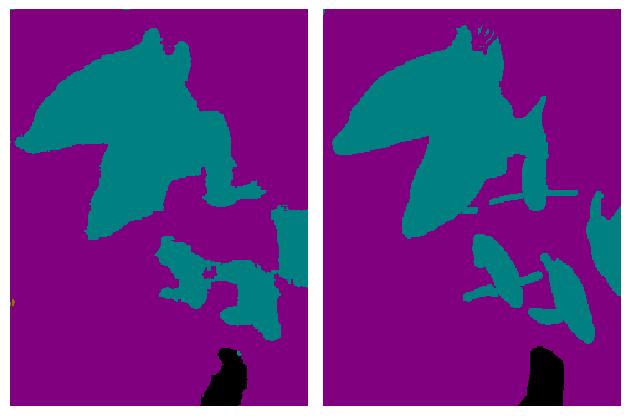

Model saved to /content/drive/MyDrive/Bveri-Abschluss/encoder_decoder_model.pth


In [ ]:
logits = encoder_decoder(images.to(device))
probs = F.softmax(logits, dim=1)
pred = probs.argmax(dim=(1), keepdim=True)
ts.show([pred[2], label_images[2]])

save_path = "/content/drive/MyDrive/Bveri-Abschluss/encoder_decoder_model.pth"
os.makedirs("/content/drive/MyDrive/Bveri-Abschluss", exist_ok=True)
torch.save(encoder_decoder.state_dict(), save_path)
print(f"Model saved to {save_path}")

In [ ]:
from tqdm import tqdm
import torch
import torch.nn.functional as F

# Initialize metrics
total_loss = 0.0
total_pixel_acc = 0.0
num_batches = len(test_loader)

criterion = nn.CrossEntropyLoss()

# Progress bar setup
pbar = tqdm(total=num_batches)
running_loss = 0.0
running_acc = 0.0

# Disable gradient computation
with torch.no_grad():  # Correct way to disable gradients
    for i, data in enumerate(test_loader):

        images, label_masks, label_images = data

        # Move data to device
        images = images.to(device)
        label_masks = label_masks.to(device)

        # Forward pass
        logits = encoder_decoder(images)
        loss = criterion(logits, label_masks)

        # Compute predictions and pixel accuracy
        probs = F.softmax(logits, dim=1)
        pred = probs.argmax(dim=1, keepdim=True).cpu()
        pixel_acc = (pred == label_images).to(torch.float).mean()

        # print statistics
        running_loss += loss.item()
        running_acc += pixel_acc
        step += 1
        print_every = 10
        if (i % print_every) == (print_every - 1):
            desc = f"Iteration: {i + 1:5d}] Loss: {running_loss / print_every:.3f} Acc: {running_acc / print_every:.3f}"
            _ = pbar.update(print_every)
            _ = pbar.set_description(desc)
            running_loss = 0.0
            running_acc = 0.0
pbar.close()

Iteration:    20] Loss: 1.508 Acc: 0.722: 100%|██████████| 20/20 [00:33<00:00,  1.65s/it]


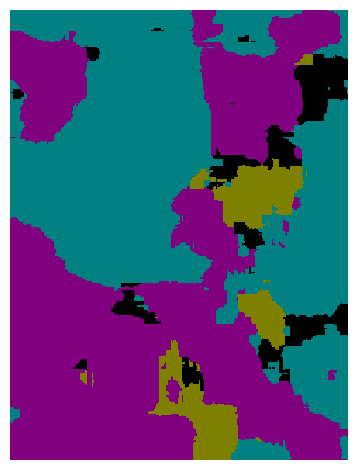

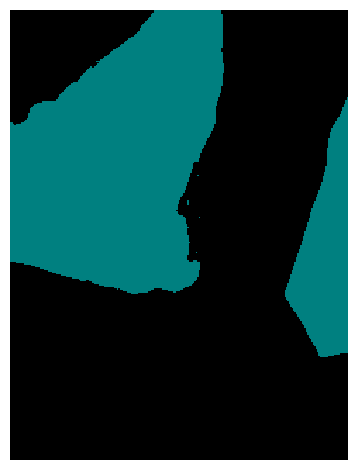

In [ ]:
logits = encoder_decoder(images.to(device))
probs = F.softmax(logits, dim=1)
pred = probs.argmax(dim=(1), keepdim=True)
ts.show(pred)
ts.show(label_images)

## Model Metrics

## Suim-Net Model

## Model Comparison